In [130]:
import geopandas as gpd
import requests 
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Garamond"
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d

load data

In [12]:
bulding_footprints = gpd.read_file("Exam_datasets/Building_Footprints.geojson") # from https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
new_york_boroughs_map = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-city-boroughs.geojson")

clean data 

In [185]:
# remove missing construction_years
bulding_footprints = bulding_footprints[-pd.isna(bulding_footprints.cnstrct_yr)].copy() 
# To int 
bulding_footprints.cnstrct_yr = bulding_footprints.cnstrct_yr.astype(int)
# Construct bins 
ten_year_bins = [0]+[year for year in range(1899,2029,10)]+[2030]
ten_year_labels = ["Before 1900"] + [str(year)+"s" for year in range(1900,2020,10)] + ["2020s"] 
# Into Bins
bulding_footprints["cnstrct_yr_intervals"] = pd.cut(bulding_footprints.cnstrct_yr, bins = ten_year_bins, labels = ten_year_labels)

## Plot Maps 

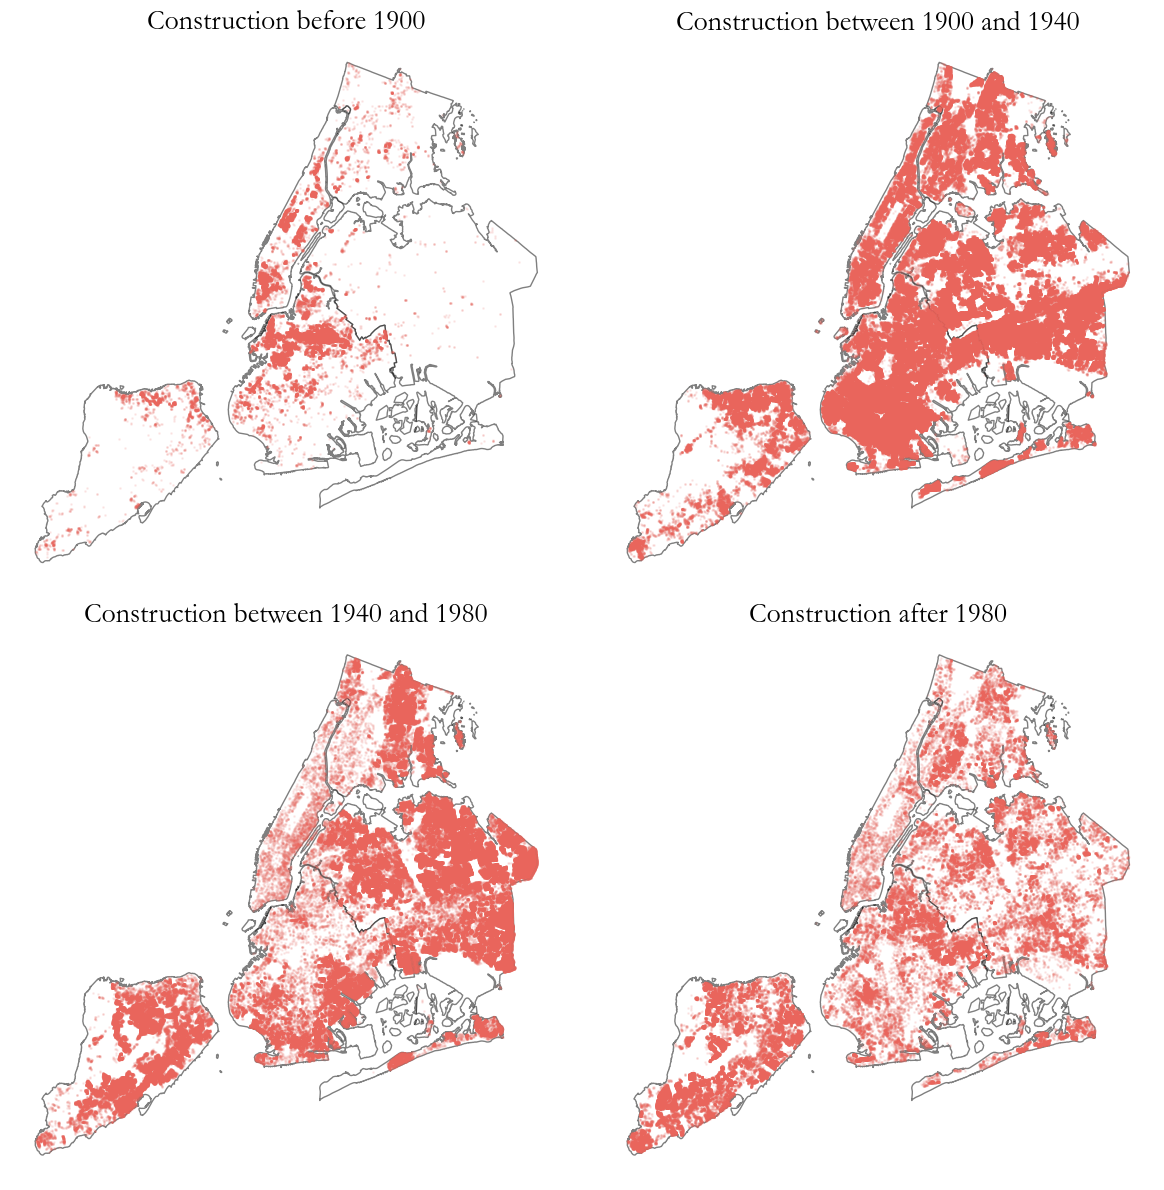

In [152]:
fig, ax = plt.subplots(2, 2, figsize = (12,12))

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][0])
bulding_footprints.query("cnstrct_yr < 1900").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][0])
ax[0][0].set_title("Construction before 1900", size = 20)
ax[0][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][1])
bulding_footprints.query("cnstrct_yr >= 1900 & cnstrct_yr < 1940").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][1])
ax[0][1].set_title("Construction between 1900 and 1940", size = 20)
ax[0][1].set_axis_off()

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][0])
bulding_footprints.query("cnstrct_yr >= 1940 & cnstrct_yr < 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][0])
ax[1][0].set_title("Construction between 1940 and 1980", size = 20)
ax[1][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][1])
bulding_footprints.query("cnstrct_yr >= 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][1])
ax[1][1].set_title("Construction after 1980", size = 20)
ax[1][1].set_axis_off()

plt.tight_layout()
plt.show()

Construction by decade 

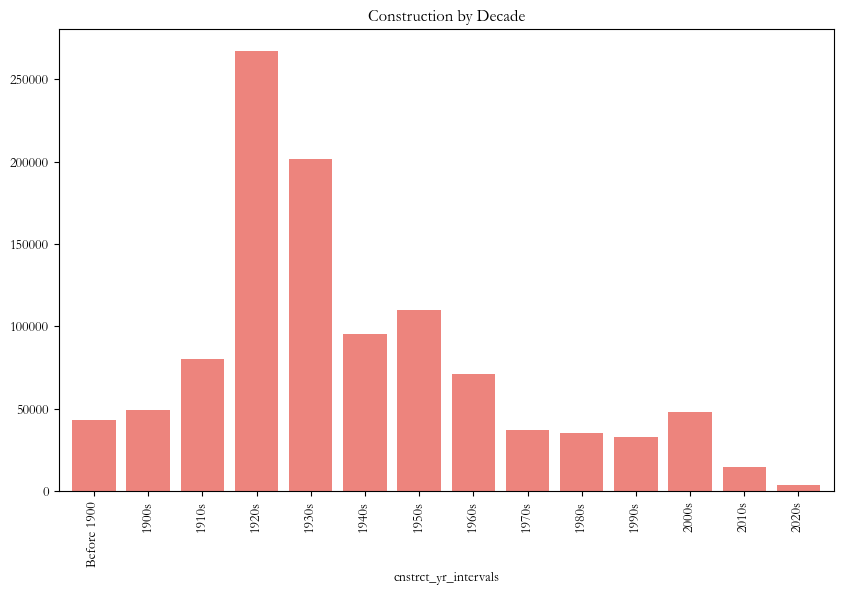

In [309]:
construction_by_year = bulding_footprints.groupby("cnstrct_yr_intervals").size().sort_index()

fig, ax  = plt.subplots(figsize = (10,6))
construction_by_year.plot.bar(color = "#E9655C", alpha = 0.8, width = 0.8)
ax.set_title("Construction by Decade")
plt.show()


# By Bourough 

In [189]:
# Reverse geocode --> Join Point on Multipolygons 
buildings_in_bouroughs = gpd.sjoin(new_york_boroughs_map, bulding_footprints)
buildings_in_bouroughs = buildings_in_bouroughs.rename(columns = {"name_left":"Bourough"})

Construction by Decade and Bourough

In [291]:
# fig, ax  = plt.subplots(figsize = (10,6))

# construction_by_decade_and_bourough = buildings_in_bouroughs.groupby(["cnstrct_yr_intervals","Bourough"]).size().reset_index().pivot(index = "cnstrct_yr_intervals", columns = "Bourough", values = 0)
# construction_by_decade_and_bourough.cumsum().plot.area(ax=ax)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_title("Cumulative Construction by Decade and Bourough")
# plt.show()

Removed early observations 

In [255]:
# Removed early observations 
buildings_in_bouroughs_trimmed = buildings_in_bouroughs.query("cnstrct_yr >= 1800")

In [288]:
#https://github.com/mwaskom/seaborn/issues/2280
# Ændre position af sns legend 
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legend_handles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

Set xtick frequency (and labels, if necesarry)

In [ ]:
## OBS - Kan bruges til at ændre xticts, men er ikke nødvendigt ift. position og label (i nedenstående er label og position dog det samme)
custom_xticks_label = []
custom_xticks_position = []

for position, year_label in enumerate(sorted(buildings_in_bouroughs_trimmed.cnstrct_yr.unique())):
    if year_label%10==0:
        custom_xticks_label.extend([year_label])
        custom_xticks_position.extend([position])

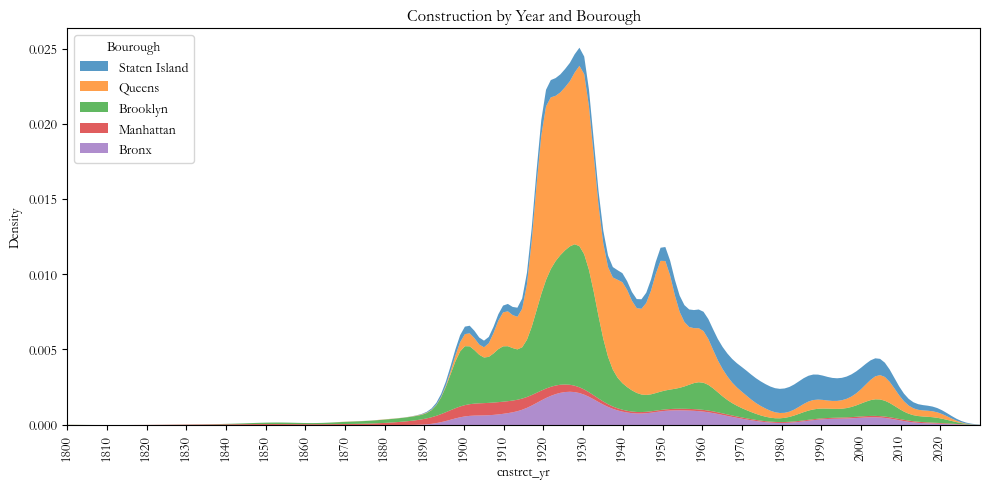

In [310]:
fig, ax  = plt.subplots(figsize = (10,5))

sns.kdeplot(buildings_in_bouroughs_trimmed, x ="cnstrct_yr", hue = "Bourough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, ax = ax)
move_legend(ax, "upper left")
custom_xticks_position = custom_xticks_label # because x is numerical
ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
ax.set_xlim([1800, 2030])
ax.set_title("Construction by Year and Bourough")

plt.tight_layout()
plt.show()

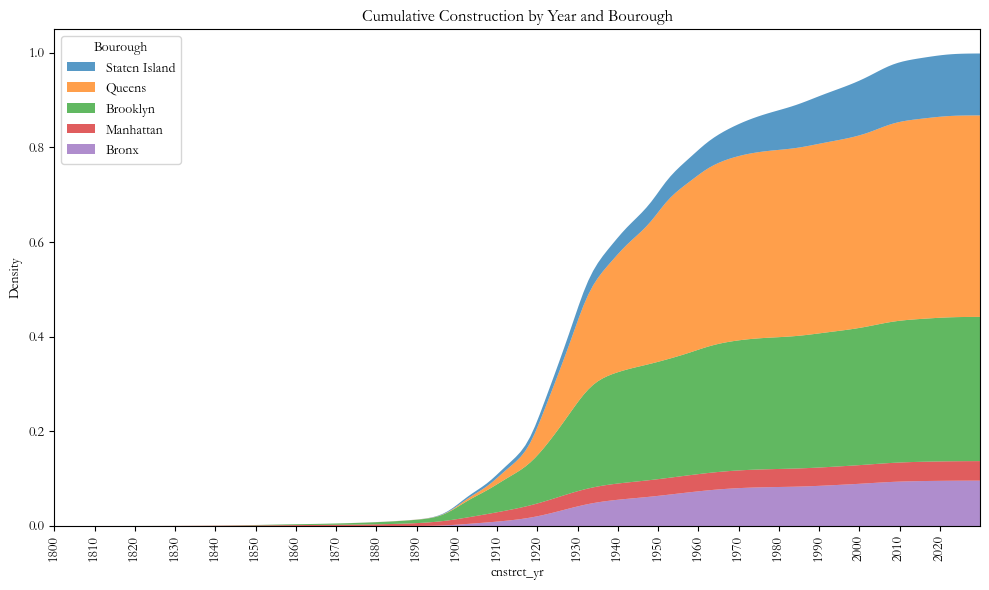

In [311]:
fig, ax  = plt.subplots(figsize = (10,6))

sns.kdeplot(buildings_in_bouroughs_trimmed, x ="cnstrct_yr", hue = "Bourough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, cumulative = True,  ax = ax)
move_legend(ax, "upper left")
custom_xticks_position = custom_xticks_label # because x is numerical
ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
ax.set_xlim([1800, 2030])
ax.set_title("Cumulative Construction by Year and Bourough")

plt.tight_layout()
plt.show()